# Data Stream Processing - Project 3 : EXstream

In [1]:
# Import librairies.
import glob
import warnings
from itertools import groupby
from typing import List, Dict, Tuple, Optional, Literal, Union, Iterable
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.cluster import AgglomerativeClustering

warnings.filterwarnings(action="ignore")

## The data

In [2]:
# Get files
DATAPATH =  "../data/custom_no_streaming_8/folder_1"
files = glob.glob(rf"{DATAPATH}/*")
files

['../data/custom_no_streaming_8/folder_1\\1_1.csv',
 '../data/custom_no_streaming_8/folder_1\\1_2.csv',
 '../data/custom_no_streaming_8/folder_1\\2_1.csv',
 '../data/custom_no_streaming_8/folder_1\\2_2.csv',
 '../data/custom_no_streaming_8/folder_1\\3_1.csv',
 '../data/custom_no_streaming_8/folder_1\\3_2.csv',
 '../data/custom_no_streaming_8/folder_1\\labels.csv']

In [3]:
# Read anomaly files and concatenate dataframes
dfs = []
for file in files[:-1]:
    df = pd.read_csv(file)
    # Extract the filename without the parent folder path and extension
    filename = file.split('\\')[-1].split('.')[0]
    # Add a new column "anomaly_type" with the extracted filename
    df.insert(1, column="trace_id", value=filename)
    df.rename({"Unnamed: 0": "time"}, axis=1, inplace=True)
    dfs.append(df)
# Concatenate all dataframes except labels.csv
anomaly_df = pd.concat(dfs)

# Create a separate dataframe for labels.csv
labels_df = pd.read_csv(files[-1], index_col=0)

# Print the resulting dataframes
print("Concatenated DataFrame (all but 'labels.csv'):\n", anomaly_df.shape)
print("\nLabels DataFrame:\n", labels_df.shape)


# # Rename values in the "anomaly_type" column based on the specified mapping
# mapping = {
#     "1_1": "bursty_input",
#     "1_2": "bursty_input",
#     "2_1": "stalled_input",
#     "2_2": "stalled_input",
#     "3_1": "cpu_contention",
#     "3_2": "cpu_contention"
# }
# anomaly_df.insert(2, column="anomaly_type", value=anomaly_df['trace_id'].replace(mapping))

# Missing values.
print("\nTotal no. missing values:\n", anomaly_df.isna().sum().sum())

Concatenated DataFrame (all but 'labels.csv'):
 (272935, 10)

Labels DataFrame:
 (29, 7)

Total no. missing values:
 0


In [4]:
def _filter_ano_time(x: pd.DataFrame):
    """
    Filter the DataFrame based on time intervals.

    Parameters:
    x (pd.DataFrame): The input DataFrame.

    Returns:
    np.ndarray: A boolean array indicating whether each row satisfies the time intervals.
    """
    return np.logical_or(x['time'].between(x['ref_start'], x['ref_end']),
                         x['time'].between(x['ano_start'], x['ano_end']))

# Merge anomaly_df and labels and filter based on time.
# Keep only point observed on annotated period. (#TODO: REMIND THIS FOR LATER)
anomaly_df = anomaly_df.merge(
    labels_df,
    how='inner',
    on='trace_id',
    suffixes=('_anomaly', '_labels'),
    validate="m:m" # remind what was expected (yes, really m:m)
).loc[lambda x: _filter_ano_time(x)]

# Add "period_type" column based on conditions
anomaly_df['period_type'] = np.where(
    anomaly_df['time'].between(anomaly_df['ref_start'], anomaly_df['ref_end']), 'I_R',
    np.where(anomaly_df['time'].between(anomaly_df['ano_start'], anomaly_df['ano_end']), 'I_A', "Not In period")
)
anomaly_df.head()


,time,trace_id,driver_BlockManager_memory_memUsed_MB_value,driver_jvm_heap_used_value,avg_jvm_heap_used_value,avg_executor_filesystem_hdfs_write_ops_value_1_diff,avg_executor_cpuTime_count_1_diff,avg_executor_runTime_count_1_diff,avg_executor_shuffleRecordsRead_count_1_diff,avg_executor_shuffleRecordsWritten_count_1_diff,ano_id,ref_start,ref_end,ano_start,ano_end,ano_type,period_type
25482,4247,1_1,2189.0,367144260.0,3.028880e+09,0.0,0.0,0.0,0.0,0.0,0,4247,6193,6193,7166,bursty_input,I_R
25488,4248,1_1,2255.0,635267260.0,4.005025e+09,0.0,494238180.0,495.0,0.0,14532.5,0,4247,6193,6193,7166,bursty_input,I_R
25494,4249,1_1,2288.0,735523600.0,4.224833e+09,34.0,802933250.0,1147.0,34207.5,10806.5,0,4247,6193,6193,7166,bursty_input,I_R
25500,4250,1_1,2142.0,760737500.0,2.231513e+09,6.0,62378130.0,490.0,7250.5,0.0,0,4247,6193,6193,7166,bursty_input,I_R
25506,4251,1_1,2125.0,770470140.0,2.237279e+09,0.0,0.0,0.0,0.0,0.0,0,4247,6193,6193,7166,bursty_input,I_R


In [5]:
continuous_features = [
        'driver_BlockManager_memory_memUsed_MB_value',
        'driver_jvm_heap_used_value',
        'avg_jvm_heap_used_value',
        'avg_executor_filesystem_hdfs_write_ops_value_1_diff',
        'avg_executor_cpuTime_count_1_diff',
        'avg_executor_runTime_count_1_diff',
        'avg_executor_shuffleRecordsRead_count_1_diff',
        'avg_executor_shuffleRecordsWritten_count_1_diff'
    ]
features_code_to_labels = {
    f"feature_{code}": feature_name 
    for code, feature_name in enumerate(continuous_features)
}
features_label_to_code = {
    value: key for key, value in features_code_to_labels.items()
}
features_code = features_code_to_labels.keys()
print(features_code_to_labels.keys())
print(features_label_to_code.keys())

anomaly_df.rename(columns=features_label_to_code, inplace=True)
anomaly_df.head()

dict_keys(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7'])
dict_keys(['driver_BlockManager_memory_memUsed_MB_value', 'driver_jvm_heap_used_value', 'avg_jvm_heap_used_value', 'avg_executor_filesystem_hdfs_write_ops_value_1_diff', 'avg_executor_cpuTime_count_1_diff', 'avg_executor_runTime_count_1_diff', 'avg_executor_shuffleRecordsRead_count_1_diff', 'avg_executor_shuffleRecordsWritten_count_1_diff'])


,time,trace_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,ano_id,ref_start,ref_end,ano_start,ano_end,ano_type,period_type
25482,4247,1_1,2189.0,367144260.0,3.028880e+09,0.0,0.0,0.0,0.0,0.0,0,4247,6193,6193,7166,bursty_input,I_R
25488,4248,1_1,2255.0,635267260.0,4.005025e+09,0.0,494238180.0,495.0,0.0,14532.5,0,4247,6193,6193,7166,bursty_input,I_R
25494,4249,1_1,2288.0,735523600.0,4.224833e+09,34.0,802933250.0,1147.0,34207.5,10806.5,0,4247,6193,6193,7166,bursty_input,I_R
25500,4250,1_1,2142.0,760737500.0,2.231513e+09,6.0,62378130.0,490.0,7250.5,0.0,0,4247,6193,6193,7166,bursty_input,I_R
25506,4251,1_1,2125.0,770470140.0,2.237279e+09,0.0,0.0,0.0,0.0,0.0,0,4247,6193,6193,7166,bursty_input,I_R


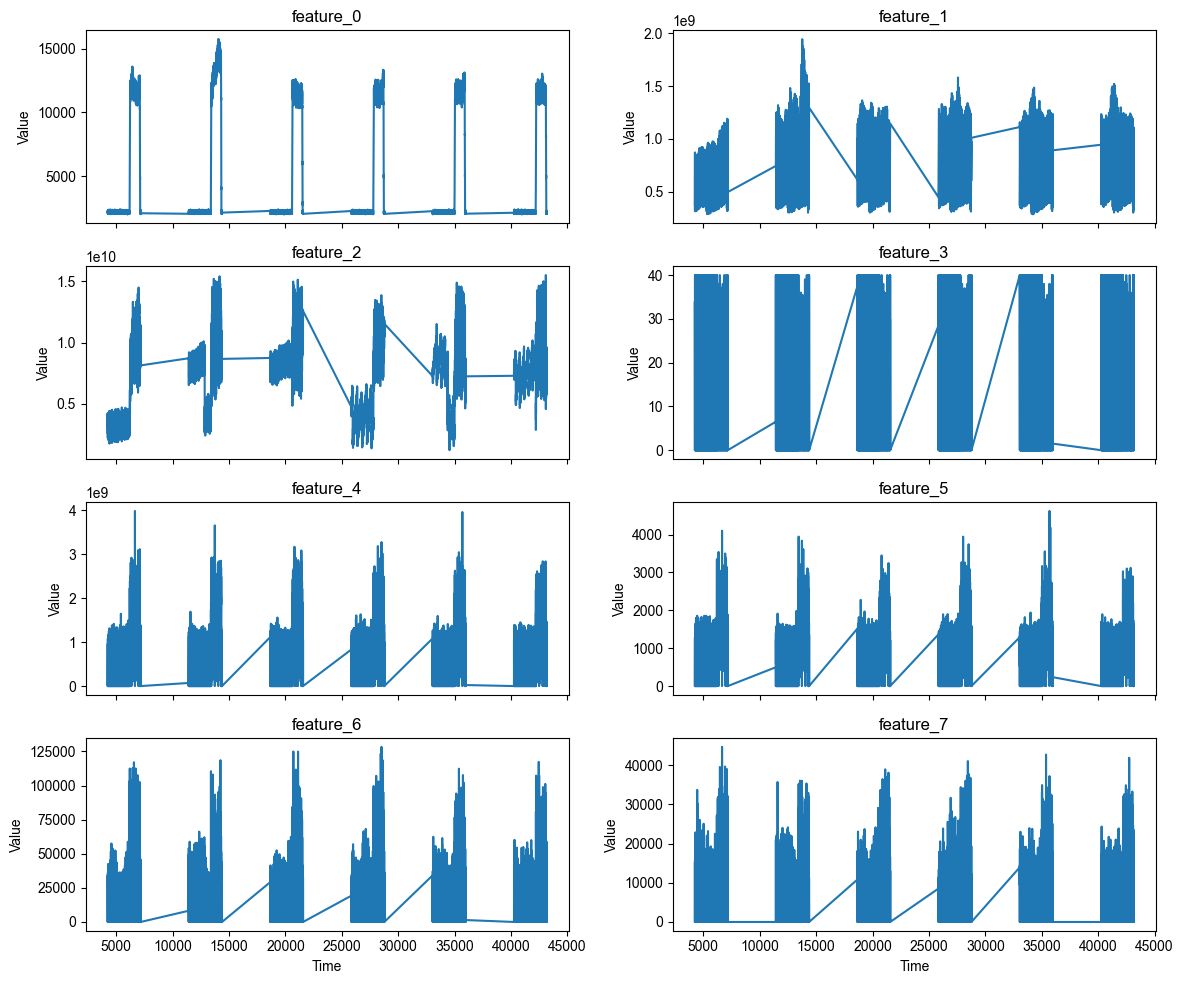

In [6]:
# Filter data for trace_id "1_1" (bursty_input)
bursty_input1_df = anomaly_df[anomaly_df["trace_id"] == "1_1"]

# Extract relevant columns
columns_to_plot = bursty_input1_df.columns[
    bursty_input1_df.columns.str.startswith("feature")
]

# Set up subplot grid
num_rows, num_cols = 4, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10), sharex=True)
sns.set(style="whitegrid")

# Plot each column in the grid
for ax, column in zip(axes.flatten(), columns_to_plot):
    sns.lineplot(x='time', y=column, data=bursty_input1_df, ax=ax)
    ax.set(title=column, xlabel='Time', ylabel='Value')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Sufficient features space

Input
- Abnormal interval: $I_A$.
- Reference interval $I_R$.

Ouput
- [ ] List of all the features occuring either during $I_A$ or $I_R$. 
  - [ ] Filter the data according to the time two intervals.
  - [ ] Remove features that do not vary during this intervals / Select all the features varying during this time interval.

In [7]:
# #---CODE HERE---- (UNUSED. NOT RELEVANT ANYMORE)
def sufficient_features_space(data: pd.DataFrame, features: List[str]) -> List[str]:
    """
    Filter the relevant features based on the given data and return the list of features with sufficient variance.

    Args:
        data (pd.DataFrame): The input dataframe containing the data.
        features (List[str]): The list of features to consider.

    Returns:
        List[str]: The list of features with sufficient variance.

    Raises:
        AttributeError: If `data` is not a dataframe.
    """
    df = data.copy()
    if isinstance(data, pd.DataFrame):
        relevant_data = df[(df["ref_start"] <= df["time"]) & (df["time"] <= df["ref_end"]) &
                             (df["ano_start"] <= df["time"]) & (df["time"] <= df["ano_end"])]
        relevant_data = relevant_data[features]
        return [col for col in relevant_data.columns if relevant_data[col].var() > 1e-16]  # Adjust var threshold
    else:
        raise AttributeError("`data` is not a dataframe")

# Example usage with bursty_input1_df
sufficient_features_space(bursty_input1_df, features_code)


['feature_0', 'feature_1', 'feature_2', 'feature_4', 'feature_5', 'feature_7']

In [8]:
def tsa_tsr_series_split(
        df: pd.DataFrame,
        trace_id: str,
        ano_id: int
        ) -> Tuple[pd.Series, pd.Series]:
    """Get annotated time series: TSA (Time Series Anomaly) and 
    TSR (Time Series Reference) of a given event, characterized by its 
    `trace_id` and its `ano_id`. 

    Parameters:
    - df (pd.DataFrame): The DataFrame containing time series data.
    - trace_id (str): The identifier for the time series.
    - ano_id (int): The identifier for the anomaly.

    Returns:
    tuple: A tuple containing two DataFrames - TSA and TSR.
    """
    tsa = df[(df['trace_id'] == trace_id)
             & (df['ano_id'] == ano_id)
             & (df['period_type'] == 'I_A')]
    tsr = df[(df['trace_id'] == trace_id)
             & (df['ano_id'] == ano_id)
             & (df['period_type'] == 'I_R')]
    
    return tsa, tsr

# Example usage:
tsa, tsr = tsa_tsr_series_split(bursty_input1_df, trace_id="1_1", ano_id=0)
print(f"TSA: Shape: {tsa.shape}. Observed period_type: {tsa['period_type'].unique()}.")
print(f"TSR: Shape: {tsr.shape}. Observed period_type: {tsr['period_type'].unique()}.")

TSA: Shape: (973, 17). Observed period_type: ['I_A'].
TSR: Shape: (1947, 17). Observed period_type: ['I_R'].


In [9]:
print(tsa["period_type"].unique())
tsa.head(2)


['I_A']


,time,trace_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,ano_id,ref_start,ref_end,ano_start,ano_end,ano_type,period_type
37164,6194,1_1,3727.0,518710720.0,2.567562e+09,0.0,1.444361e+09,1622.0,0.0,17005.5,0,4247,6193,6193,7166,bursty_input,I_A
37170,6195,1_1,4095.0,531104740.0,2.571189e+09,0.0,1.984284e+09,2164.0,0.0,27154.0,0,4247,6193,6193,7166,bursty_input,I_A


In [10]:
print(tsr["period_type"].unique())
tsr.head(2)

['I_R']


,time,trace_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,ano_id,ref_start,ref_end,ano_start,ano_end,ano_type,period_type
25482,4247,1_1,2189.0,367144260.0,3.028880e+09,0.0,0.0,0.0,0.0,0.0,0,4247,6193,6193,7166,bursty_input,I_R
25488,4248,1_1,2255.0,635267260.0,4.005025e+09,0.0,494238180.0,495.0,0.0,14532.5,0,4247,6193,6193,7166,bursty_input,I_R


## Single feature reward (section 4)

Workflow:
* [x] Class Entropy
* [x] Segmentation Entropy
* [x] Penalization (for mixed segments)
* [x] Normalization by feature size

### Class entropy

**Input**
* $TS_A$, $TS_R$ two time series from the abnormal and the reference intervals respectively.

**Compute**

* $|TS_A|$, $|TS_A|$: number of points in the two series.
* The weight of each series (empirical probability that one point belong to that class).
$$
    p_A = \frac{|TS_A|}{|TS_A| + |TS_R|}, \quad p_R = \frac{|TS_R|}{|TS_A| + |TS_R|}
$$
* The class entropy of the feature $f$:
$$
    H_{Class}(f) = p_A \cdot \log\left(\frac{1}{p_A}\right) + p_R \cdot \log\left(\frac{1}{p_R}\right)
$$

In [11]:
#---CODE HERE----
def class_entropy(ts_anomaly: Iterable[float], ts_reference: Iterable[float]) -> float:
    """
    Calculate the class entropy based on the number of instances in
    TSA (True Samples for Anomaly) and TSR (True Samples for Regular).

    Parameters:
    - TSA (Iterable[float]): List or array containing instances
        classified as True Anomalies.
    - TSR (Iterable[float]): List or array containing instances
        classified as True Regular.

    Returns:
    float: The calculated class entropy.
    """
    p_A = len(ts_anomaly) / (len(ts_anomaly) + len(ts_reference))
    p_R = len(ts_reference) / (len(ts_anomaly) + len(ts_reference))

    H_Class_f = -(p_A * np.log2(p_A) + p_R * np.log2(p_R))
    return H_Class_f

# example with trace_id = 1_1 and ano_id = 1
TSA, TSR = tsa.copy(), tsr.copy()
class_entropy(TSA, TSR)

0.9181816365001072

### Segmentation entropy (???)

**Input**
* Time series $TS$ of a feature $f$: $(X_t)_{t=1,\dots,T}$. 
* Anomaly time annotations: $A_S = (a_s)_{s=1,\dots, S}  \subset \{1, \dots, T\}$  

Example: In the sequence, AANNNNANNN. The anomaly time anotations would be (1,2,7). We are given only the different time intervals from which we have to derive the different anomaly time anotation and then the segment (this is just an heuristic, not necessarily the way it would be implemented).

**Compute**
* The segments. A segment is a (contiguous) sequence of point with the same label (anomaly or not anomaly)
* The segmentation entropy of the feature $f$:
$$
    H_{Segmentation}(f) = \sum_{i=1}^{n} p_i \cdot \log\left(\frac{1}{p_i}\right)
$$

### Penalization for mixed segments

$$
    H^+_{Segmentation}(f) = H_{Segmentation}(f) + \sum_{j=1}^{m} H_{Segmentation}(c_j^*)
$$

In [12]:
def generate_TS(df: pd.DataFrame, variable: str) -> pd.Series:
    """
    Generate a time series (TS) for a given variable based on unique combinations
    of 'variable' and 'period_type' in the input DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing the data.
    - variable (str): The variable for which the time series is generated.

    Returns:
    pd.Series: The generated time series.
    """
    # Use set to get unique combinations of 'variable' and 'period_type'
    unique_values = df[[variable, 'period_type']].drop_duplicates()
    
    # Determine the period type for each unique value
    TS = unique_values.groupby(variable)['period_type'].apply(
        lambda x: 'I_M' if set(x) == {'I_R', 'I_A'} else x.iloc[0]
    )
    return TS

def penalized_segmentation_entropy(TS: pd.Series) -> float:
    """
    Calculate the segmentation entropy with a penalty for mixed segments.

    Parameters:
    - TS (pd.Series): Time series data.

    Returns:
    float: The calculated segmentation entropy with mixed segment penalty.
    """
    # Group the series by consecutive identical values and get segment lengths
    segments = [(k, sum(1 for _ in g)) for k, g in groupby(TS)]
    
    # Filter segments for 'I_R' and 'I_A' only
    relevant_segments = [(label, length) for label, length in segments
                         if label in ['I_R', 'I_A']]
    
    # Calculate segment probabilities
    total_length = sum(length for _, length in relevant_segments)
    probabilities = [length / total_length for _, length in relevant_segments
                     if total_length > 0]
    
    # Calculate segmentation entropy
    H_Segmentation_f = -np.sum(np.fromiter(
        (p * np.log2(p) for p in probabilities if p > 0), dtype=float)
    )  # avoid log(0)

    # Penalty for mixed segments
    penalty = np.sum(
        np.fromiter(
            (
                1/length * np.log2(1/length) for label, length in segments 
                if label == 'I_M' for _ in range(length)
            ),
            dtype=float)
    )

    return H_Segmentation_f - penalty  # Subtract the penalty

feature = "feature_0"
TS = generate_TS(pd.concat([TSA, TSR]), feature)
print(TS.unique())
print(f"The segmentation entropy with mixed segment penalty for {feature}, is: {penalized_segmentation_entropy(TS)}")


['I_R' 'I_M' 'I_A']
The segmentation entropy with mixed segment penalty for feature_0, is: 5.633053894394429


groupby(TS): This groups the TS series by consecutive identical values. It returns keys (k) and groups (g). The key is the value around which the grouping is done (e.g., 'I_R', 'I_A', or 'I_M'), and the group is an iterator that you can loop over to get all items in the group.

### Normalization by feature size

$$ D(f) = \frac{H_{Class}(f)}{H^+_{Segmentation}(f)} $$


In [13]:
def entropy_based_reward(
        class_entropy_value: float, 
        penalized_segmentation_entropy_value: float) -> float:
    """
    Calculate the entropy-based feature distance.

    Args:
    - class_entropy_value (float): The class entropy of the feature.
    - penalized_segmentation_entropy_value (float): The regularized segmentation 
      entropy of the feature.

    Returns:
    float: The normalized entropy-based feature distance.
    """
    return (class_entropy_value / penalized_segmentation_entropy_value
            if penalized_segmentation_entropy_value != 0 else 0)

Distance = entropy_based_reward(class_entropy(TSA, TSR), 
                                    penalized_segmentation_entropy(TS))
print(f"Feature Distance: {Distance}")

def single_feature_reward(df, feature, trace_id, ano_id):
    """
    Calculate the reward for a single feature based on entropy.

    Parameters:
    df (DataFrame): The input dataframe.
    feature (str): The name of the feature.
    trace_id (str): The trace ID column name.
    ano_id (str): The anomaly ID column name.

    Returns:
    float: The entropy-based reward for the feature.
    """
    
    ts_ano, ts_ref = tsa_tsr_series_split(df, trace_id=trace_id, ano_id=ano_id)
    ts = generate_TS(pd.concat([ts_ano, ts_ref]), feature)
    ts_class_entropy = class_entropy(tsa, tsr)
    ts_segment_entropy = penalized_segmentation_entropy(ts)
    entropy_based_reward(ts_class_entropy, ts_segment_entropy)

    return entropy_based_reward(ts_class_entropy, ts_segment_entropy)


feature = "feature_0"
reward = single_feature_reward(
    bursty_input1_df, feature=feature, trace_id="1_1", ano_id=0
)
print(f"The single-feature reward of '{feature}': {reward}")
    


Feature Distance: 0.16299890853410956
The single-feature reward of 'feature_0': 0.16299890853410956


## Constructing explanations (section 5)

# Step 1
5.1 Step 1: reward leap filtering The single-feature distance function produces a ranking of
all features based on their individual rewards. Sharp changesin the reward between successive features in the ranking indicate a semantic change: Features that rank below a sharp drop in the reward are unlikely to contribute to an explanation. Therefore, features whose distance is low, relatively to
other features, can be safely discarded.

Features with more complex segmentation have lower rewards

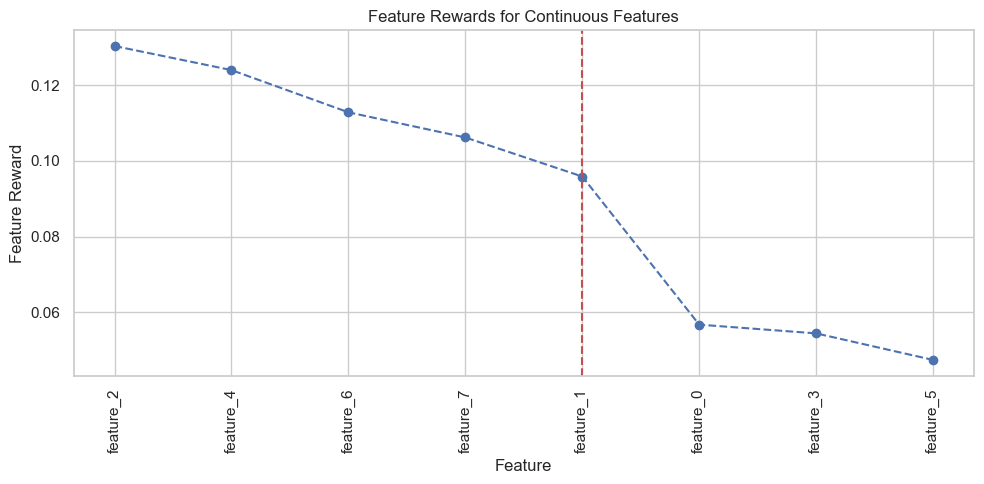

Significant features: ['feature_2', 'feature_4', 'feature_6', 'feature_7', 'feature_1']


In [25]:
def compute_feature_rewards(df: pd.DataFrame, trace_id: str, ano_id: int, features_code: List[str]) -> Dict[str, float]:
    """
    Computes feature rewards for continuous features.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the features.
    - trace_id (str): The trace ID.
    - ano_id (int): The anomaly ID.
    - features_code (List[str]): List of feature names.

    Returns:
    - dict: Dictionary containing feature names and their corresponding rewards.
    """
    feature_rewards = {
        feature: single_feature_reward(
            df, feature=feature, trace_id=trace_id, ano_id=ano_id
        )
        for feature in features_code
    }
    return feature_rewards

import numpy as np
import matplotlib.pyplot as plt

def select_feature_on_rewards(df, trace_id, ano_id, features_code, ignore_first=False, plot=True, verbose=True):
    """
    Plots the feature rewards for continuous features and identifies the elbow point.
    Optionally ignores the first sharpest drop if it is the first feature.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the features.
    - trace_id (str): The trace ID.
    - ano_id (int): The anomaly ID.
    - features_code (List[str]): List of feature names.
    - ignore_first (bool, optional): Whether to ignore the first sharpest drop. Defaults to False.
    - plot (bool, optional): Whether to plot the feature rewards. Defaults to True.
    - verbose (bool, optional): Whether to print detailed information. Defaults to True.

    Returns:
    - List[str]: The significant features identified up to the elbow point.
    """
    feature_rewards = compute_feature_rewards(
        df, trace_id=trace_id, ano_id=ano_id, features_code=features_code
        )
    sorted_features = sorted(feature_rewards.items(), key=lambda x: x[1], reverse=True)
    variables, rewards = zip(*sorted_features)

    # Calculate differences between successive feature rewards
    differences = np.abs(np.diff(rewards))
    elbow_point = np.argmax(differences)

    # Check if the elbow point is the first feature and whether to ignore it
    if ignore_first and elbow_point == 0:
        second_largest_drop = np.argmax(differences[1:]) + 1  # Offset by 1 due to slicing
        elbow_point = second_largest_drop

    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(variables, rewards, marker='o', linestyle='--', color='b')
        plt.xlabel('Feature')
        plt.ylabel('Feature Reward')
        plt.title('Feature Rewards for Continuous Features')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.axvline(x=variables[elbow_point], color='r', linestyle='--')
        plt.show()

    significant_features = list(variables[:elbow_point + 1])  # Include elbow_point

    if verbose:
        print("Significant features:", significant_features)

    return significant_features

# Example usage
significant_features_1_1_1 = select_feature_on_rewards(bursty_input1_df, "1_1", 1, features_code, ignore_first=True)


* Gotcha, I told you guy, "feature_0" is not returned"

# Step 2: false positive filtering

# Step 3: filtering by correlation clustering

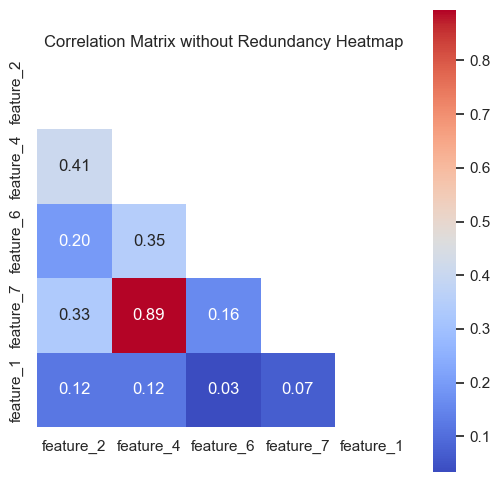

Cluster 0: feature_2, feature_4, feature_7
Representative features: feature_2

Cluster 1: feature_1
Representative features: feature_1

Cluster 2: feature_6
Representative features: feature_6

Selected representative characteristics:  ['feature_2', 'feature_1', 'feature_6']


In [30]:
def process_trace_anomaly(
    df: pd.DataFrame,
    trace_id: str,
    ano_id: int,
    selected_features: List[str],
    plot_correlation: bool = False,
    threshold: float = 0.8,
    linkage: str = 'complete',
    verbose: bool = True,
) -> List[str]:
    """
    Process the trace anomaly by performing the following steps:
    1. Retrieve the TSA (Trace Start Anomaly) and TSR (Trace Stop Anomaly) data
    for the given trace_id and ano_id.
    2. Concatenate the TSA and TSR data and select the specified features.
    3. Calculate the correlation matrix of the selected features.
    4. Cluster the strongly correlated features using agglomerative clustering.
    5. Identify the representative features for each cluster.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the features.
    - trace_id (str): The ID of the trace.
    - ano_id (int): The ID of the anomaly.
    - selected_features (List[str]): The list of selected features.
    - threshold (float, optional): The threshold for identifying strong
      correlations. Defaults to 0.8.
    - linkage (str, optional): The linkage method for agglomerative clustering.
      Defaults to 'complete'.

    Returns:
    - representative_features (List[str]): The list of representative features
      for each cluster.

    #TODO: Idea for False Positive Filtering (why don't we simply add time in 
    #   agglomerative clustering)  Then, we remove all features in the same 
    #   cluster than him. 
    # Pay attention to exclude time when looking for best "single_feature_reward"
    #   in its cluster.
    # ==> This is equivalent to simply drop the cluster containing afterward.
    """
    # Check that only one feature is selected
    if len(selected_features) == 1:
        if verbose:
            print(f"Only one feature selected: {selected_features[0]}")
        return selected_features
    # Retrieve the TSA (Trace Start Anomaly) and TSR (Trace Stop Anomaly) data
    # for the given trace_id and ano_id
    tsa, tsr = tsa_tsr_series_split(df, trace_id=trace_id, ano_id=ano_id)

    # Concatenate the TSA and TSR data and select the specified features
    data: pd.DataFrame = pd.concat([tsa, tsr])[selected_features]

    # Calculate the correlation matrix of the selected features
    corr_matrix = data.corr().abs()
    # Create a mask to hide the upper triangle of the correlation matrix for aesthetics.
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    if plot_correlation:
        # Create a heatmap to visualize the correlation matrix without redundancy
        plt.figure(figsize=(6, 6))
        sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f",
                    cmap='coolwarm', square=True)
        plt.title('Correlation Matrix without Redundancy Heatmap')
        plt.show()

    # Cluster the strongly correlated features using agglomerative clustering.
    clustering = AgglomerativeClustering(
        n_clusters=None, affinity='precomputed', linkage=linkage,
        distance_threshold=threshold)
    clustering.fit(1 - corr_matrix)  # 1 - corr_matrix b/c agglomerative clustering uses distances

    # Identify the representative features for each cluster.
    cluster_labels = clustering.labels_
    unique_clusters = np.unique(cluster_labels)
    representative_features = []

    for cluster in unique_clusters:
        # Select the features in the cluster.
        indices = np.where(cluster_labels == cluster)[0] # feature indices
        features_in_cluster = corr_matrix.columns[indices] # feature names
        if "time" in features_in_cluster: # just in case someone include "time" by mistake.
            features_in_cluster.drop("time")

        # Calculate single feature reward for each feature in the cluster.
        feature_rewards = {
            feature: single_feature_reward(df, feature, trace_id, ano_id)
            for feature in features_in_cluster
        }
        # Select the feature with the highest reward.
        selected_feature = max(
            feature_rewards, key=feature_rewards.get
        )
        representative_features.append(selected_feature)

    # print the representative features and associated features for each cluster
    for cluster in unique_clusters:
        indices = np.where(cluster_labels == cluster)[0]
        if verbose:
            print(f"Cluster {cluster}:", ", ".join(data.columns[indices]))
            print(f"Representative features: {representative_features[cluster]}\n")

    if verbose:
        print("Selected representative characteristics: ",
              representative_features)

    return representative_features


# Example
representative_features_1_1_1 = process_trace_anomaly(
    bursty_input1_df, '1_1', 1, significant_features_1_1_1, plot_correlation=True,
    threshold=0.8, linkage='complete', verbose=True)


# 5.4 Building final explanations (for human reading and aesthetics)


data = 1 2 4 7 10
cumsum = 1 3 7 14 24
inverse_cumsum = 24 14 7 3 1
range(1, len(data + 1)) = 1 2 3 4 5
data/cumsum = 1 3/2 7/3 14/4 24/5 (1 1.5 2.33 3.5 4.75)
data/inverse_cumsum 1/24

In [16]:


# def find_optimal_threshold(df, trace_id, ano_id, feature, bins=10):
#     # Split the time series into normal and abnormal data
#     tsa, tsr = tsa_tsr_series_split(df, trace_id=trace_id, ano_id=ano_id)

#     # Combine reference and abnormal data
#     combined_data = pd.concat([tsa[feature], tsr[feature]]).sort_values().reset_index(drop=True)

#     # Calculate the cumulative sum of the sorted data
#     cumulative_sum = np.cumsum(combined_data)

#     # Calculate the cumulative sum in reverse order
#     cumulative_sum_reverse = np.cumsum(combined_data.iloc[::-1]).iloc[::-1]

#     # Calculate the information gain for each split point
#     information_gain = -calculate_entropy(combined_data) - calculate_entropy(cumulative_sum / np.arange(1, len(combined_data) + 1))
#     information_gain -= calculate_entropy(cumulative_sum_reverse / np.arange(1, len(combined_data) + 1))

#     # Find the index of the maximum information gain
#     optimal_index = np.argmax(information_gain)

#     # Return the optimal threshold and corresponding information gain
#     return combined_data[optimal_index] #, information_gain[optimal_index]



In [17]:
#TODO: HAS TO BE IMPROVED
def calculate_entropy(data, bins=10):
    """
    Calculate the entropy for a distribution of data.

    Parameters:
    data (array-like): The input data.

    Returns:
    float: The entropy value.
    """
    hist, _ = np.histogram(data, bins=bins)

    return entropy(hist)


def find_optimal_threshold(df, trace_id, ano_id, feature, bins=10):
    tsa, tsr = tsa_tsr_series_split(df, trace_id=trace_id, ano_id=ano_id)
    combined_data = pd.concat([tsa[feature], tsr[feature]]).sort_values()

    # Initialiser le seuil optimal et le gain d'information maximal
    optimal_threshold = None
    max_information_gain = -np.inf

    # Use binary search over the potential split points
    low = 0
    high = len(combined_data) - 1
    while low <= high:
        mid = (low + high) // 2
        threshold = combined_data.iloc[mid]
        lower_entropy = calculate_entropy(combined_data[combined_data <= threshold], bins=bins)
        upper_entropy = calculate_entropy(combined_data[combined_data > threshold], bins=bins)
        information_gain = - lower_entropy - upper_entropy

        # Update the optimal threshold if the information gain is higher
        if information_gain > max_information_gain:
            max_information_gain = information_gain
            optimal_threshold = threshold

        # If the information gain is the same on both sides, we can stop
        if information_gain == max_information_gain:
            break
        elif information_gain < max_information_gain:
            high = mid - 1
        else:
            low = mid + 1

    return optimal_threshold


def find_abnormal_intervals(df, trace_id, ano_id, feature, bins=10):
    optimal_threshold = find_optimal_threshold(df, trace_id, ano_id, feature, bins=bins)
    return [(None, optimal_threshold)]  # Retourne un intervalle sous la forme (min, seuil)

def feature_explanation_predicate(df, trace_id, ano_id, feature, bins=10):
    # Trouver les intervalles anormaux pour la caractéristique
    abnormal_intervals = find_abnormal_intervals(df, trace_id, ano_id, feature, bins=bins)

    # Construire les prédicats pour la caractéristique
    predicates = []
    for interval in abnormal_intervals:
        if interval[0] is None:  # Seuil supérieur seulement
            predicates.append(f"{feature} ≤ {interval[1]}")
        elif interval[1] is None:  # Seuil inférieur seulement
            predicates.append(f"{feature} ≥ {interval[0]}")
        else:  # Intervalle complet
            predicates.append(f"({feature} ≥ {interval[0]} ∧ {feature} ≤ {interval[1]})")

    # Joindre les prédicats par "∨" (disjonction)
    return " ∨ ".join(predicates)

# Exemple d'utilisation
# tsa, tsr = tsa_tsr_series_split(bursty_input1_df, trace_id="1_1", ano_id=1)
# TSA, TSR = tsa.copy(), tsr.copy()

feature = "feature_0"
optimal_threshold = find_optimal_threshold(
    df=bursty_input1_df, trace_id="1_1", ano_id=0, feature=feature)
print("Seuil optimal :", optimal_threshold)

feature_explanation_predicate(df=bursty_input1_df, trace_id="1_1", ano_id=0, feature=feature)


Seuil optimal : 2275.0


'feature_0 ≤ 2275.0'

In [32]:
def build_explanation(
        df,
        trace_id,
        ano_id,
        features,
        plot_rewards=False,
        plot_correlation=False,
        threshold=0.8,
        linkage='complete', 
        ignore_first : bool = False,
        verbose: bool = False):
    # Step 1: Reward leap filtering (select features based on reward)
    selected_features = select_feature_on_rewards(
        df, 
        trace_id=trace_id,
        ano_id=ano_id,
        features_code=features,
        plot=plot_rewards,
        verbose=verbose,
        ignore_first=ignore_first,

    )

    # Step 2: False Positive Filtering (#TODO: Coming soon...)

    # Step 3: Filtering by correlation clustering
    representative_features = process_trace_anomaly(df, 
                                                    trace_id=trace_id, 
                                                    ano_id=ano_id, 
                                                    selected_features=selected_features, 
                                                    plot_correlation=plot_correlation, 
                                                    threshold=threshold, 
                                                    linkage=linkage, 
                                                    verbose=verbose)
    
    return representative_features

build_explanation(
    bursty_input1_df, 
    trace_id="1_1", 
    ano_id=1, 
    features=features_code, 
    plot_rewards=False, 
    plot_correlation=False,
    verbose=False,
    ignore_first=False
)

['feature_2', 'feature_1', 'feature_6']

## Stability


```
instability(df, trace_id, ano_id, features, repeat=5, sample_frac=0.8, replace=False, random_state=42):
    # INPUTS:
    #   df: DataFrame containing the data
    #   trace_id: Trace ID for the anomaly
    #   ano_id: Anomaly ID
    #   features: List of features to analyze
    #   repeat: Number of times to repeat the process for stability estimation (default is 5)
    #   sample_frac: Fraction of the DataFrame to use for each sample during instability calculation (default is 0.8)
    #   replace: Whether to sample with replacement (default is False)
    #   random_state: Random seed for reproducibility (default is 42)

    # Set random seed for reproducibility
    Set random seed to random_state

    # Filter the DataFrame to the specified anomaly
    single_ano_df = Filter rows in df where trace_id matches trace_id and ano_id matches ano_id

    # Initialize an empty list to store explanatory features
    all_explanatory_features = []

    # Repeat the following steps 'repeat' times
    For each _ in range(repeat):
        # Randomly subsample 80% of the dataframe
        sample_df = Randomly sample sample_frac fraction of rows from single_ano_df with or without replacement

        # Build an explanation using the subsample
        explanatory_features = build_explanation(sample_df, trace_id, ano_id, features)

        # Add the explanation features to the list
        Append explanatory_features to all_explanatory_features

    # Compute the frequency of each feature in the list
    feature_counts = Count occurrences of each feature in all_explanatory_features

    # Compute consistency as entropy using the feature frequencies
    consistency = Calculate entropy using feature_counts

    # Return the computed consistency
    Return consistency
```


In [19]:
def instability(
    df: pd.DataFrame,
    trace_id: str,
    ano_id: int,
    features: List[str],
    plot_rewards: bool = False,
    plot_correlation: bool = False,
    verbose: bool = False,
    threshold: float = 0.8,
    linkage: str = 'complete',
    repeat: int = 5,
    sample_frac: int = 0.8,
    replace: bool = False,
    random_state: int = 42
):
    """
    Calculate the instability (consistency as entropy) of feature explanations for a specific anomaly in a DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        trace_id (str): The trace ID for the anomaly.
        ano_id (int): The anomaly ID.
        features (List[str]): The list of features to analyze.
        repeat (int): Number of times to repeat the process for stability estimation.
        sample_frac (float): Fraction of the DataFrame to use for each sample during instability calculation.
        replace (bool): Whether to sample with replacement.
        random_state (int): Random seed for reproducibility.

    Returns:
        float: Instability (consistency as entropy) of feature explanations.
    """
    np.random.seed(random_state) # for reproducibility

    # 1. Filter the DataFrame to the specified anomaly
    single_ano_df = df[(df["trace_id"] == trace_id) & (df["ano_id"] == ano_id)]
    
    # 2. Get all the set of explanation features.
    all_explanatory_features = [
        build_explanation(
            single_ano_df.sample(frac=sample_frac, replace=replace),
            trace_id=trace_id,
            ano_id=ano_id,
            features=features,
            plot_rewards=plot_rewards,
            plot_correlation=plot_correlation,
            threshold=threshold,
            linkage=linkage,
            verbose=verbose
        ) for _ in range(repeat)
    ]

    # 3. Compute the frequency for each feature in the list.
    feature_counts = pd.Series(
        np.concatenate(all_explanatory_features)).value_counts(normalize=True)

    # 4. Compute consistency as entropy using the previous frequency.
    consistency = -np.sum(feature_counts * np.log2(feature_counts))

    return consistency


In [20]:
instability(bursty_input1_df, trace_id="1_1", ano_id=0, features=features_code)

ValueError: Found array with 1 sample(s) (shape=(1, 1)) while a minimum of 2 is required by AgglomerativeClustering.

## Compare with explanation based on decision Tree

# Creation of outputs : folder_1_results.csv 

Expected output  : a CSV file with as columns:

- trace_id
- ano_id
- exp_size
- exp_instability, which is computed by subsampling 80% of the data (from both the reference and anomalous periods) to generate an explanation and repeating this 5 times to compute the instability metric. 
- explanation (using feature integer indices, not the names, to be shorter in display).


In [ ]:
bursty_input1_df

,time,trace_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,ano_id,ref_start,ref_end,ano_start,ano_end,ano_type,period_type
25482,4247,1_1,2189.0,367144260.0,3.028880e+09,0.0,0.000000e+00,0.0,0.0,0.0,0,4247,6193,6193,7166,bursty_input,I_R
25488,4248,1_1,2255.0,635267260.0,4.005025e+09,0.0,4.942382e+08,495.0,0.0,14532.5,0,4247,6193,6193,7166,bursty_input,I_R
25494,4249,1_1,2288.0,735523600.0,4.224833e+09,34.0,8.029332e+08,1147.0,34207.5,10806.5,0,4247,6193,6193,7166,bursty_input,I_R
25500,4250,1_1,2142.0,760737500.0,2.231513e+09,6.0,6.237813e+07,490.0,7250.5,0.0,0,4247,6193,6193,7166,bursty_input,I_R
25506,4251,1_1,2125.0,770470140.0,2.237279e+09,0.0,0.000000e+00,0.0,0.0,0.0,0,4247,6193,6193,7166,bursty_input,I_R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258947,43157,1_1,2197.0,617228400.0,6.751344e+09,0.0,0.000000e+00,0.0,0.0,0.0,5,40257,42193,42193,43161,bursty_input,I_A
258953,43158,1_1,2247.0,643717100.0,7.865795e+09,0.0,4.823995e+08,484.0,0.0,11780.5,5,40257,42193,42193,43161,bursty_input,I_A
258959,43159,1_1,2297.0,678391000.0,6.606992e+09,36.0,1.220047e+09,1587.0,38721.0,15064.0,5,40257,42193,42193,43161,bursty_input,I_A
258965,43160,1_1,2065.0,709914200.0,6.690486e+09,4.0,4.512965e+07,60.0,4448.5,0.0,5,40257,42193,42193,43161,bursty_input,I_A


In [ ]:
# Get the list of anomalies
anomalies = labels_df[['trace_id', 'ano_id']].values.tolist()

# Liste pour stocker les dictionnaires de résultats
results_list = []

for trace_id, ano_id in anomalies:
    # Générer l'explication
    explanation_features = build_explanation(
        anomaly_df[anomaly_df["trace_id"] == trace_id], 
        trace_id=trace_id, 
        ano_id=ano_id, 
        features=features_code,
        plot_rewards=False, 
        plot_correlation=False,
        verbose=False
    )
    
    # Calculer l'instabilité
    exp_size = len(explanation_features)
    exp_instability = instability(
        bursty_input1_df, 
        trace_id=trace_id, 
        ano_id=ano_id, 
        features=features_code
    )
    
    # Ajouter les résultats à la liste
    results_list.append({
        'trace_id': trace_id,
        'ano_id': ano_id,
        'exp_size': exp_size,
        'exp_instability': exp_instability,
        'explanation': ', '.join(explanation_features)
    })

# Créer DataFrame à partir de la liste de dictionnaires
results_df = pd.DataFrame(results_list)

# Exporter en CSV
results_df.to_csv('folder_1_results.csv', index=False)


ValueError: at least one array or dtype is required

Trace ID: 1_1, Anomaly ID: 0


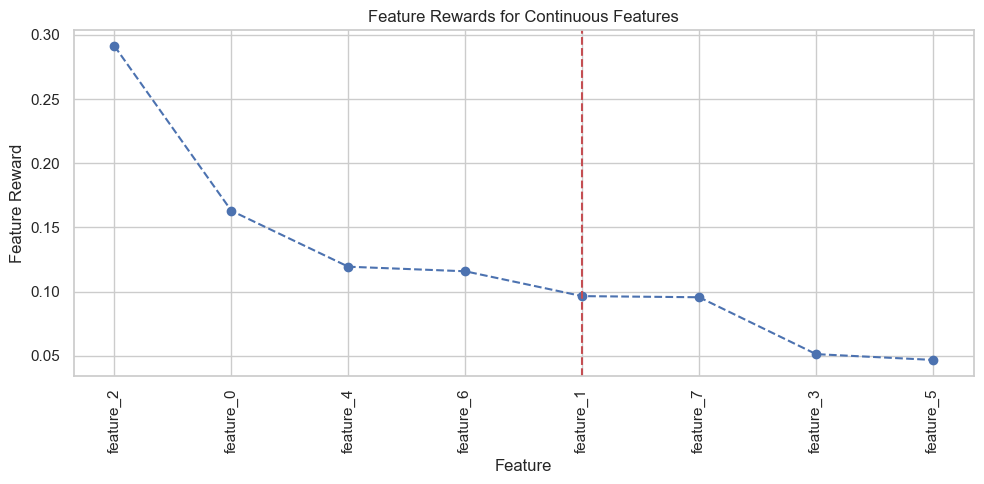

Trace ID: 1_1, Anomaly ID: 1


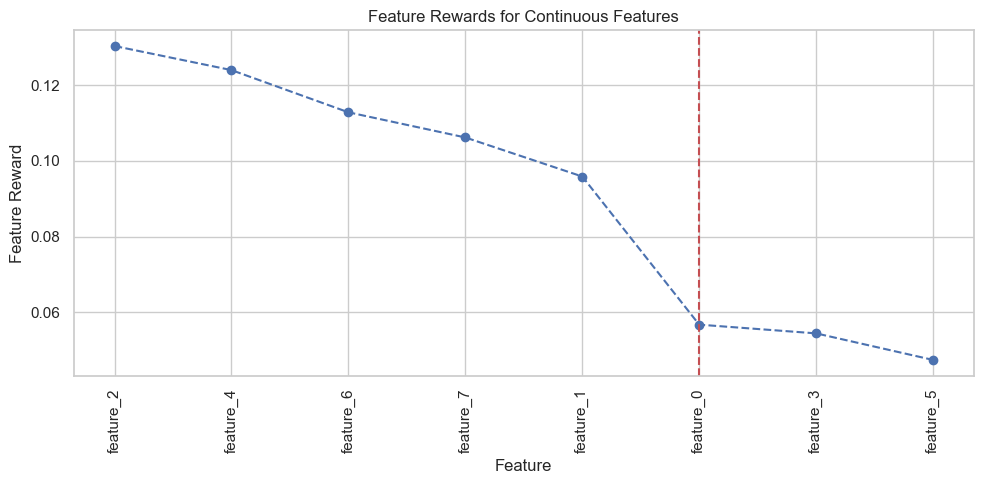

Trace ID: 1_1, Anomaly ID: 2


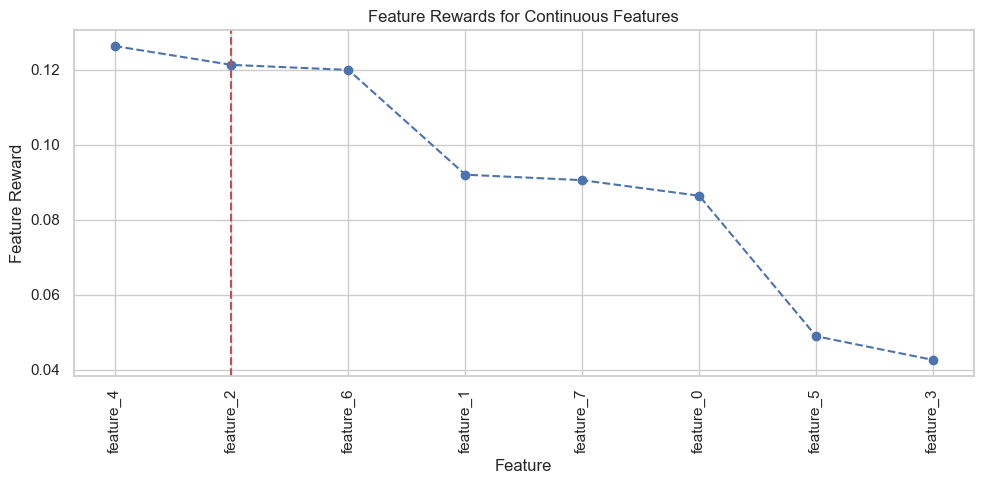

ValueError: Found array with 1 sample(s) (shape=(1, 1)) while a minimum of 2 is required by AgglomerativeClustering.

In [ ]:
for trace_id, ano_id in anomalies:
    print(f"Trace ID: {trace_id}, Anomaly ID: {ano_id}")
    # Générer l'explication
    explanation_features = build_explanation(
        anomaly_df[anomaly_df["trace_id"] == trace_id], 
        trace_id=trace_id, 
        ano_id=ano_id, 
        features=features_code,
        plot_rewards=True, 
        plot_correlation=False,
        verbose=False
    )

Trace ID: 1_1, Anomaly ID: 0


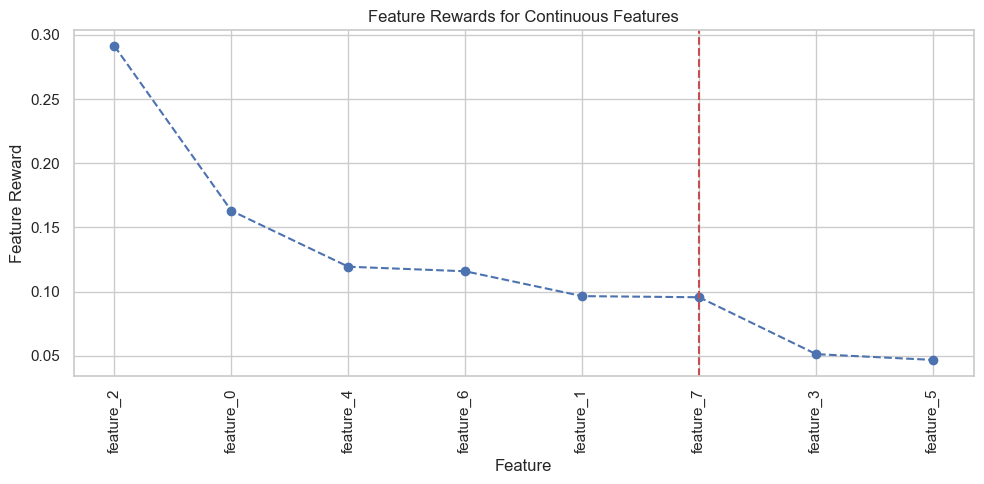

Trace ID: 1_1, Anomaly ID: 1


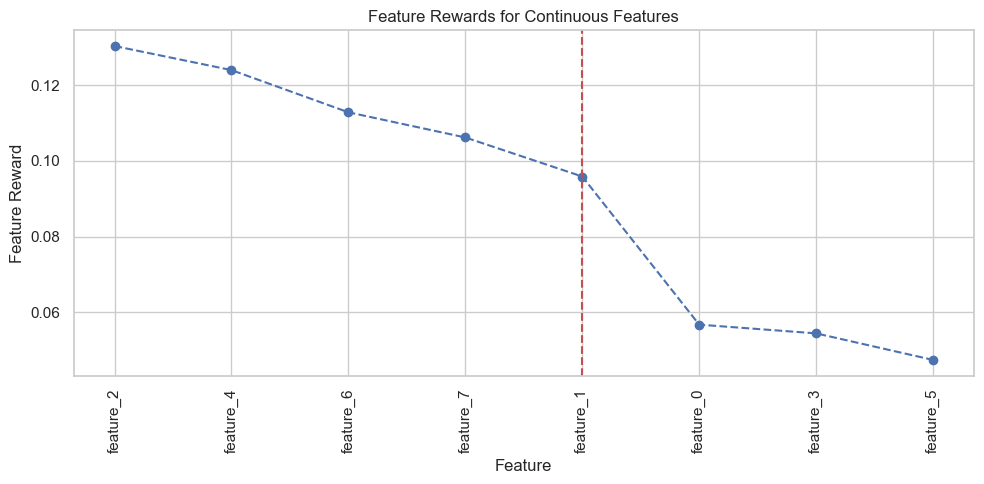

Trace ID: 1_1, Anomaly ID: 2


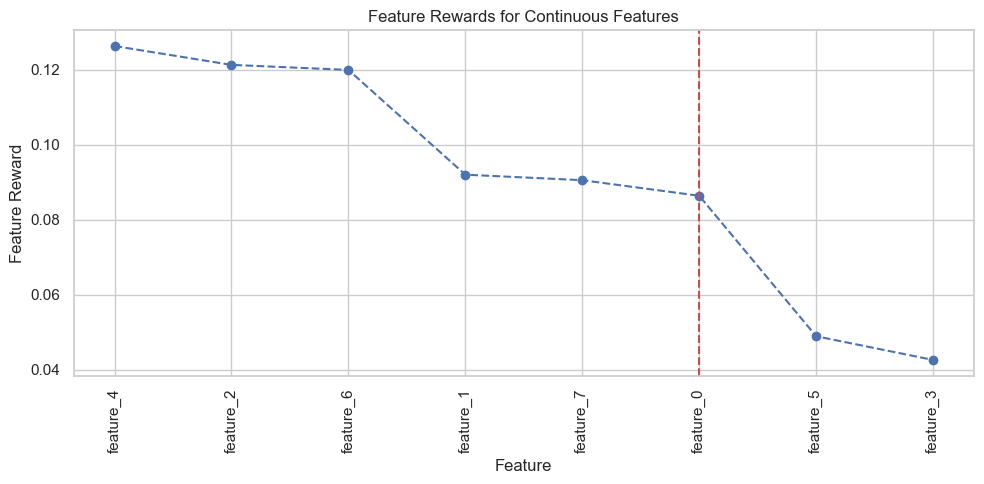

Trace ID: 1_1, Anomaly ID: 3


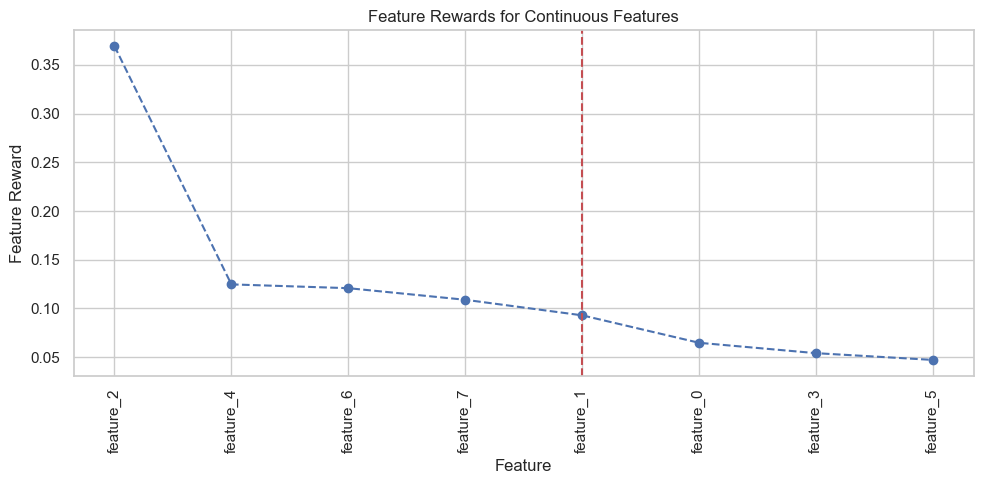

Trace ID: 1_1, Anomaly ID: 4


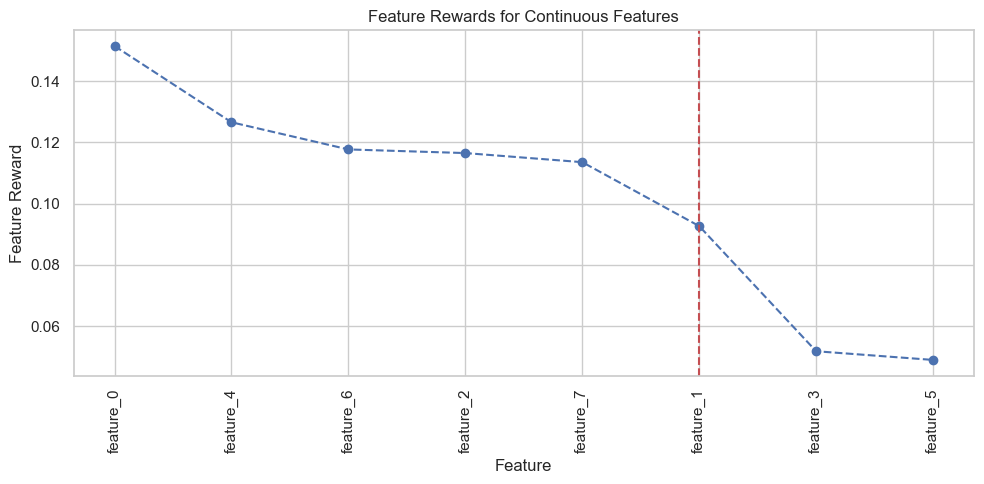

Trace ID: 1_1, Anomaly ID: 5


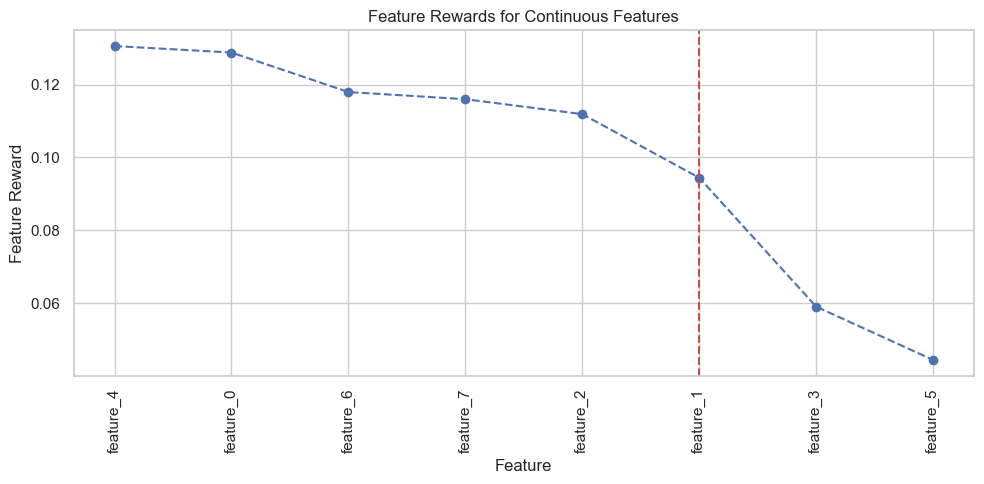

Trace ID: 1_2, Anomaly ID: 0


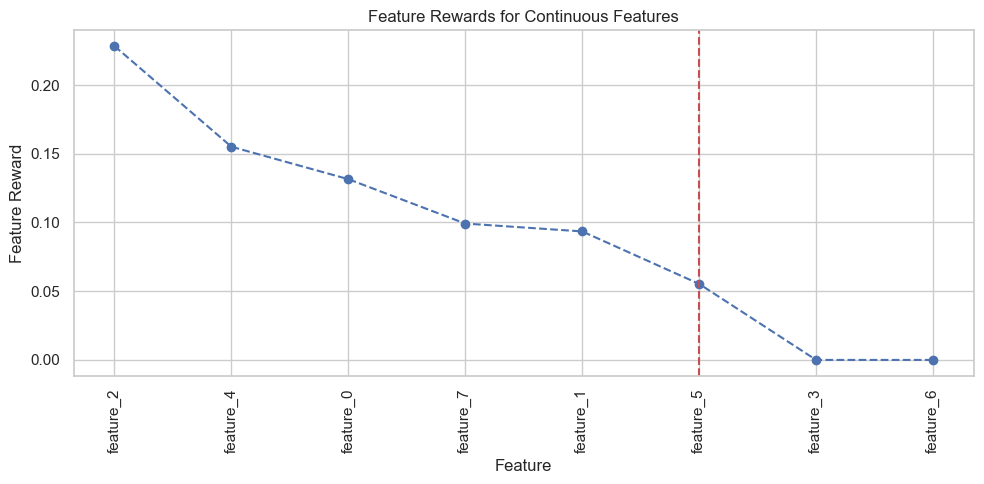

Trace ID: 1_2, Anomaly ID: 1


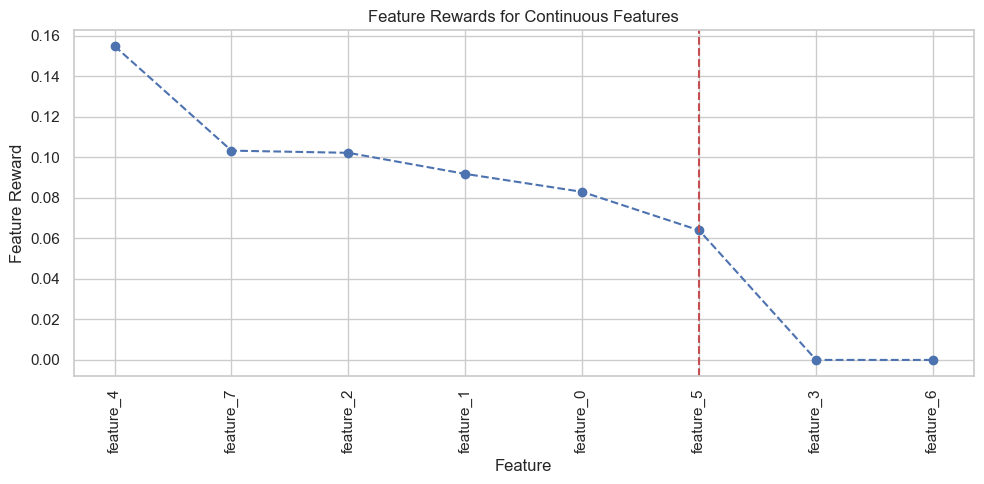

Trace ID: 1_2, Anomaly ID: 2


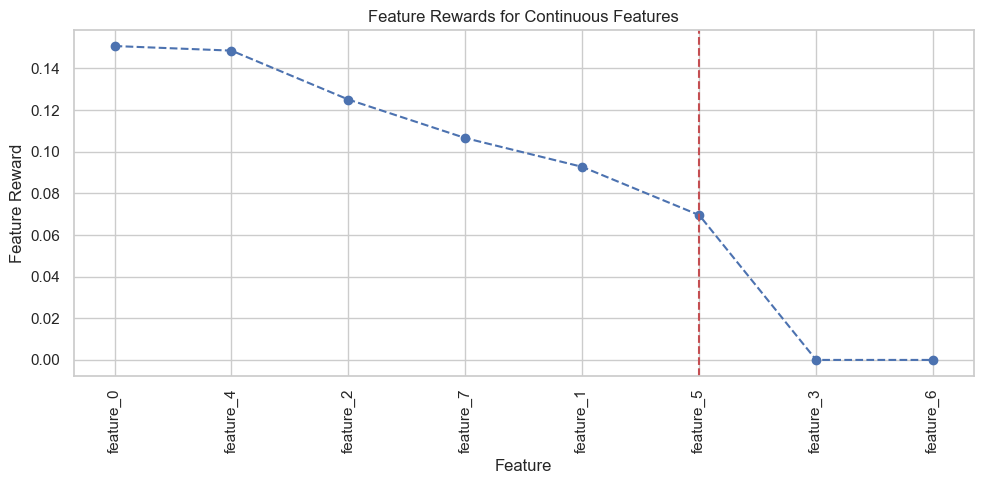

Trace ID: 1_2, Anomaly ID: 3


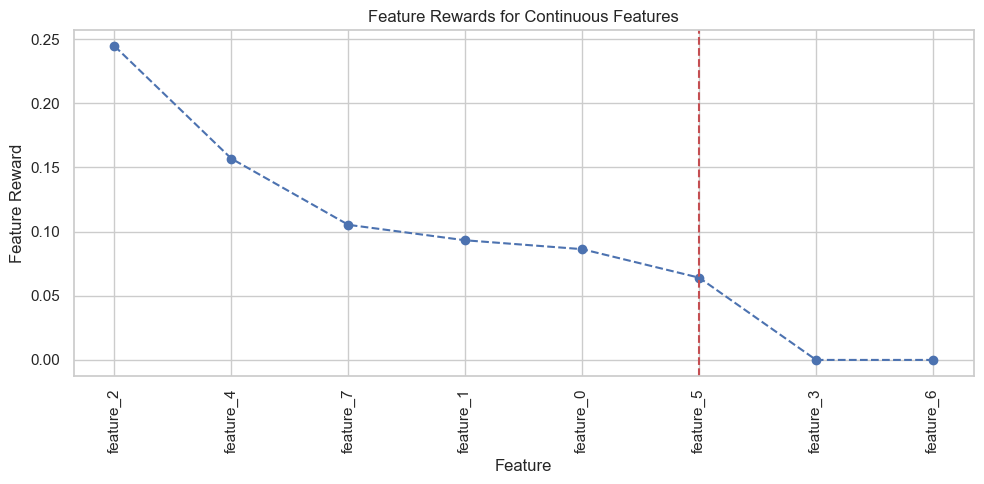

Trace ID: 1_2, Anomaly ID: 4


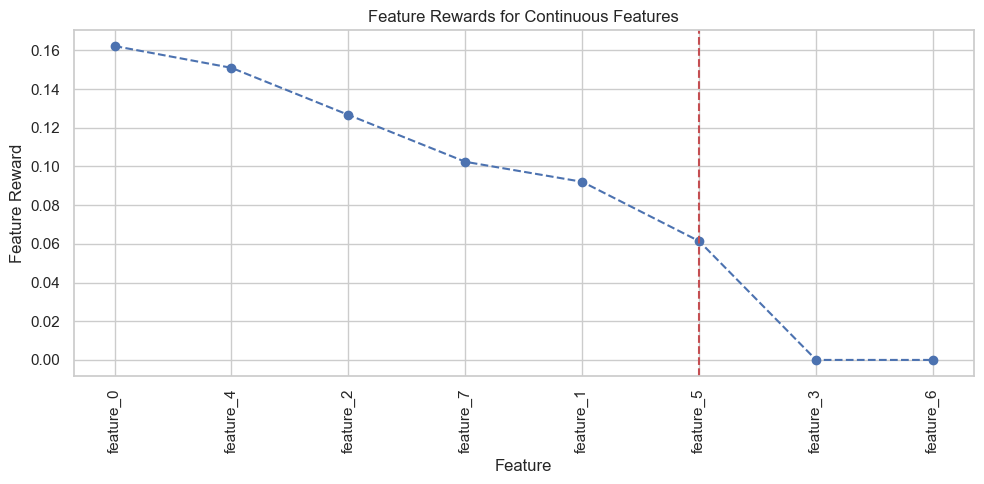

Trace ID: 2_1, Anomaly ID: 0


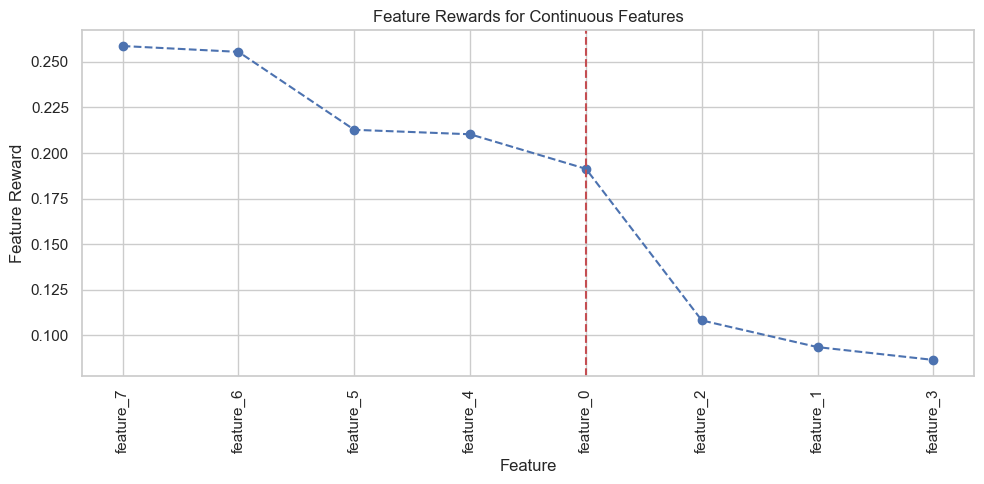

Trace ID: 2_1, Anomaly ID: 1


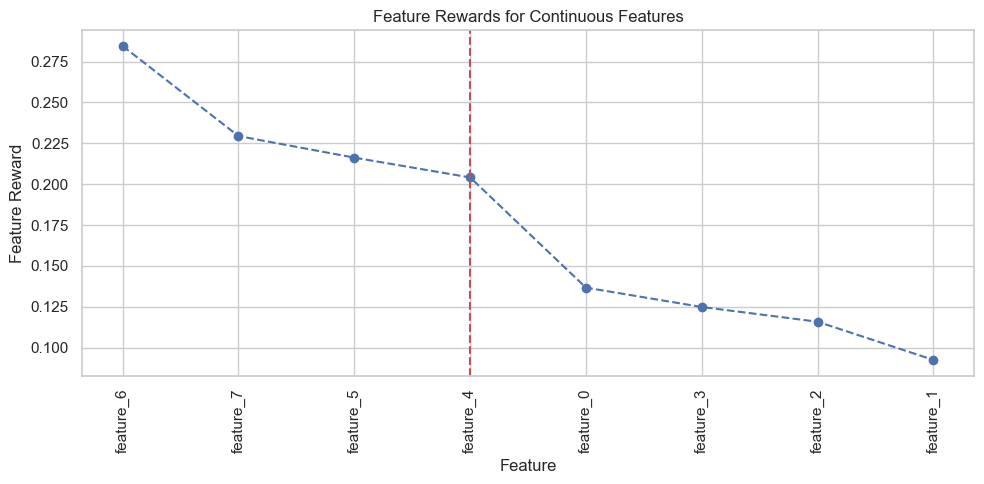

Trace ID: 2_1, Anomaly ID: 2


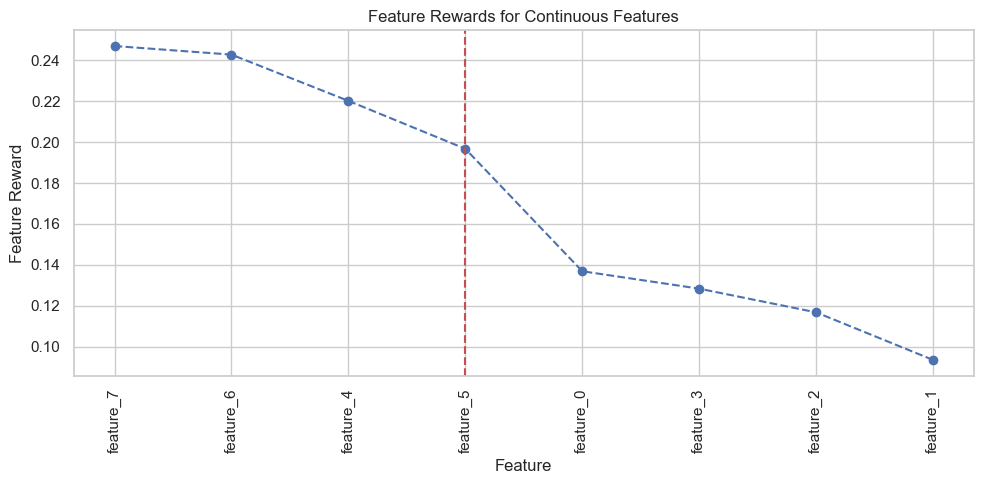

Trace ID: 2_1, Anomaly ID: 3


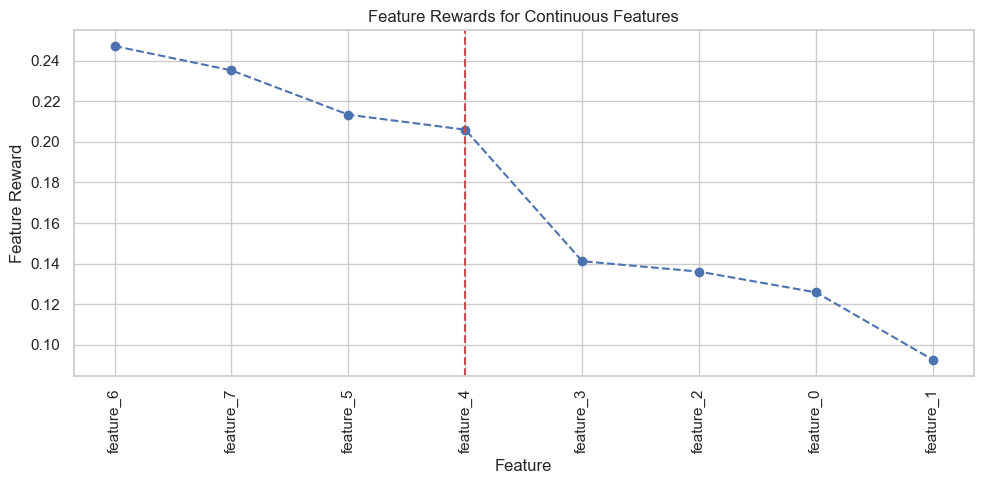

Trace ID: 2_2, Anomaly ID: 0


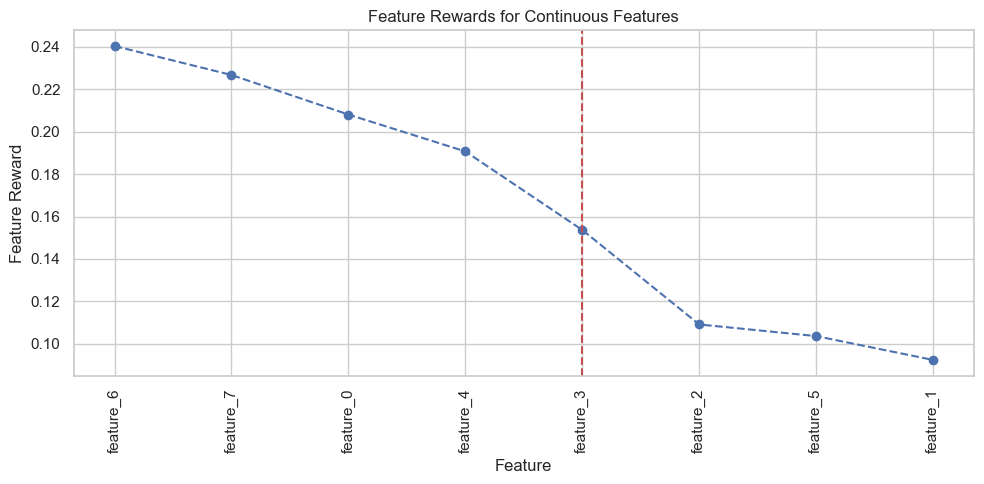

Trace ID: 2_2, Anomaly ID: 1


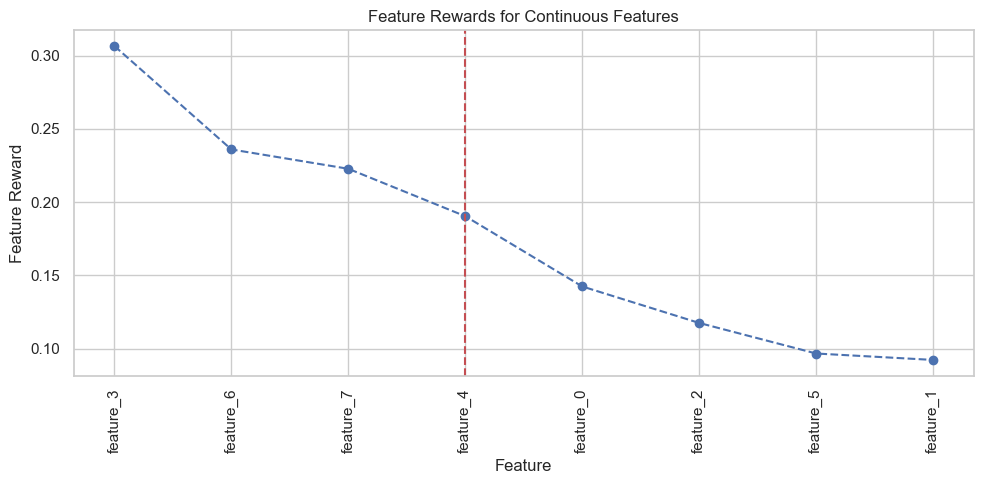

Trace ID: 2_2, Anomaly ID: 2


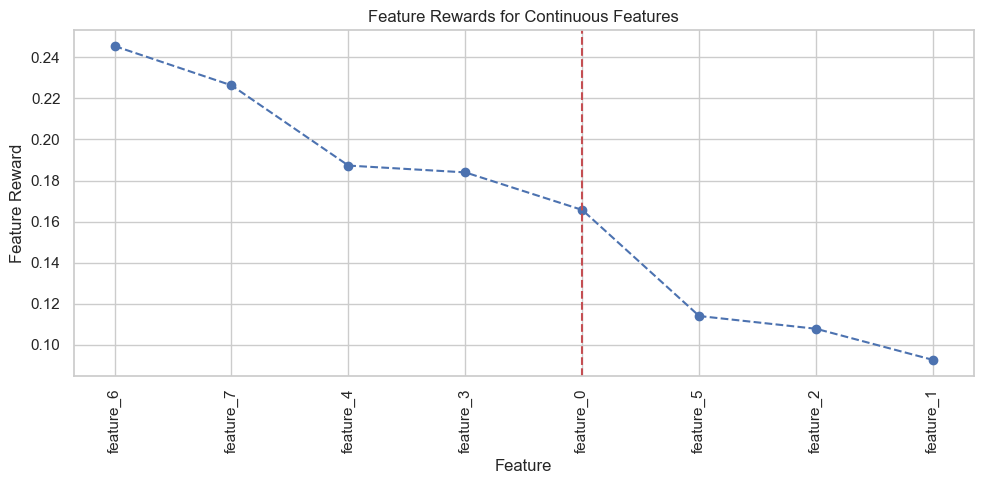

Trace ID: 2_2, Anomaly ID: 3


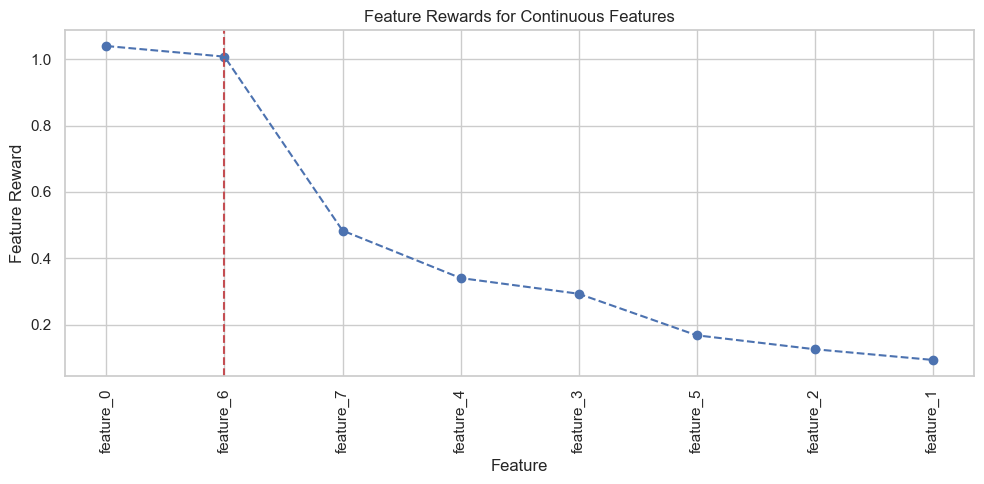

Trace ID: 3_1, Anomaly ID: 0


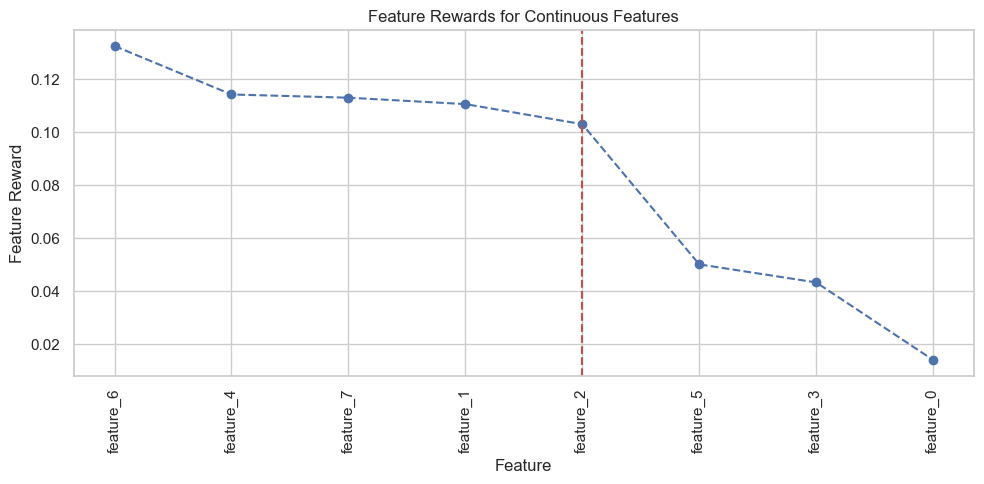

Trace ID: 3_1, Anomaly ID: 1


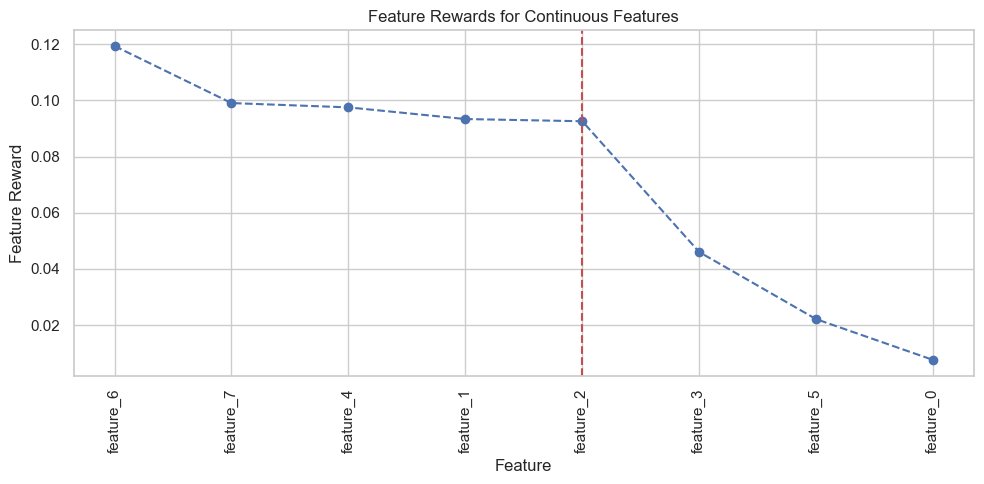

Trace ID: 3_1, Anomaly ID: 2


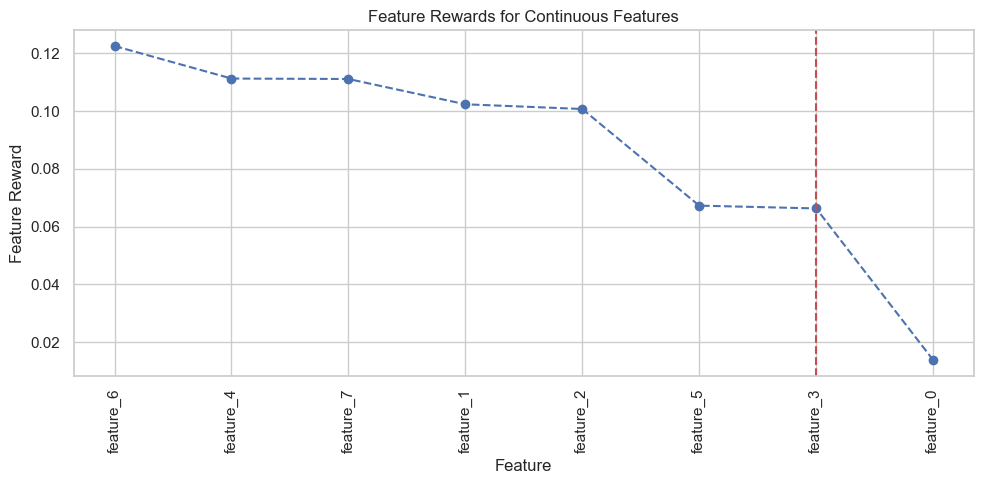

Trace ID: 3_1, Anomaly ID: 3


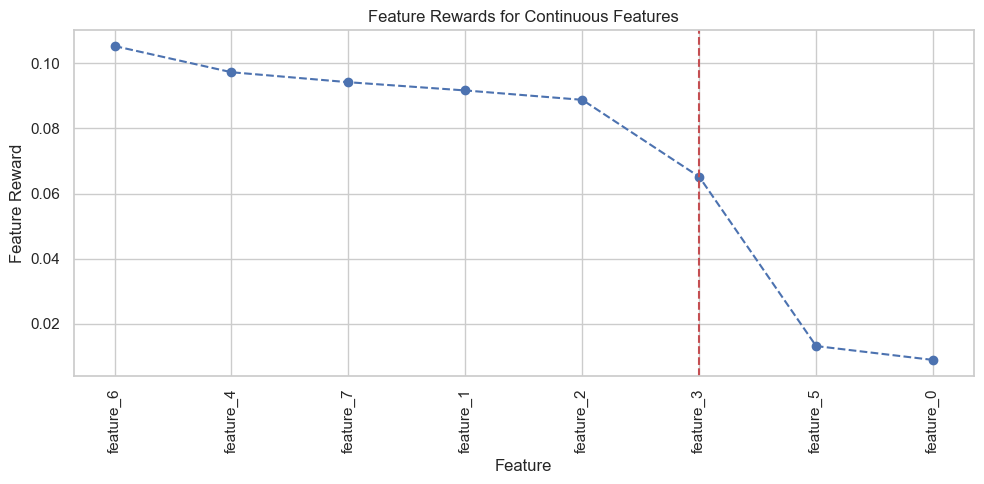

Trace ID: 3_1, Anomaly ID: 4


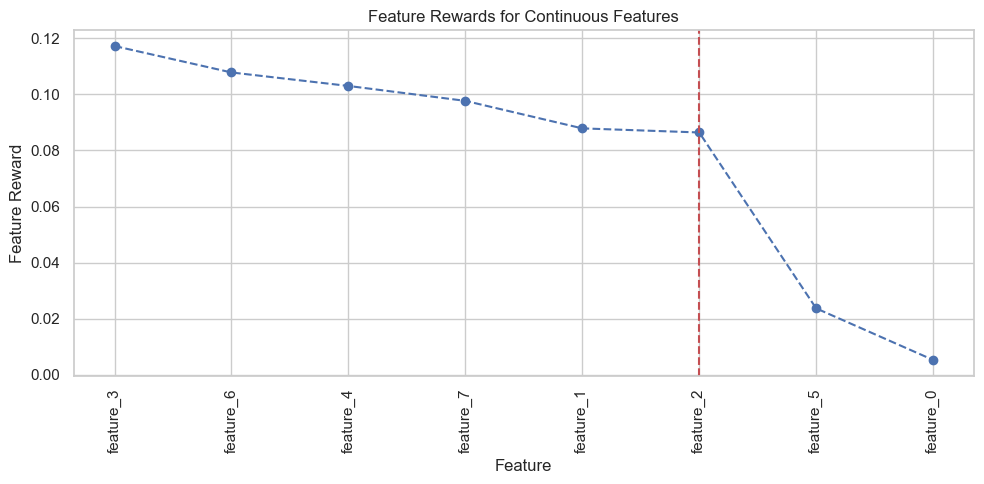

Trace ID: 3_2, Anomaly ID: 0


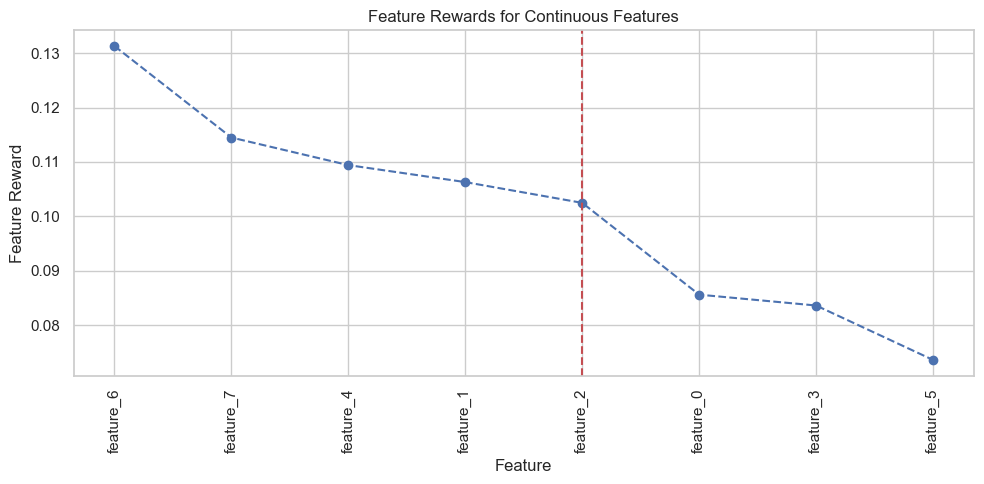

Trace ID: 3_2, Anomaly ID: 1


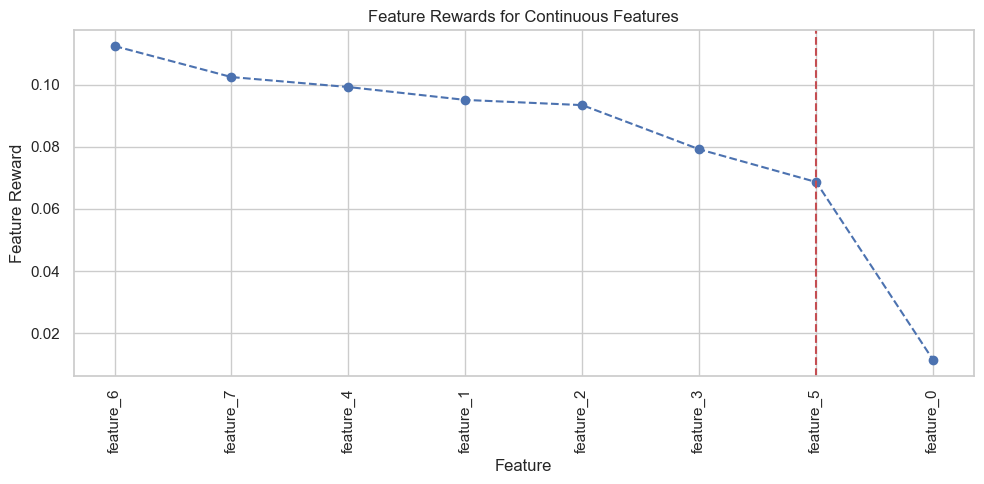

Trace ID: 3_2, Anomaly ID: 2


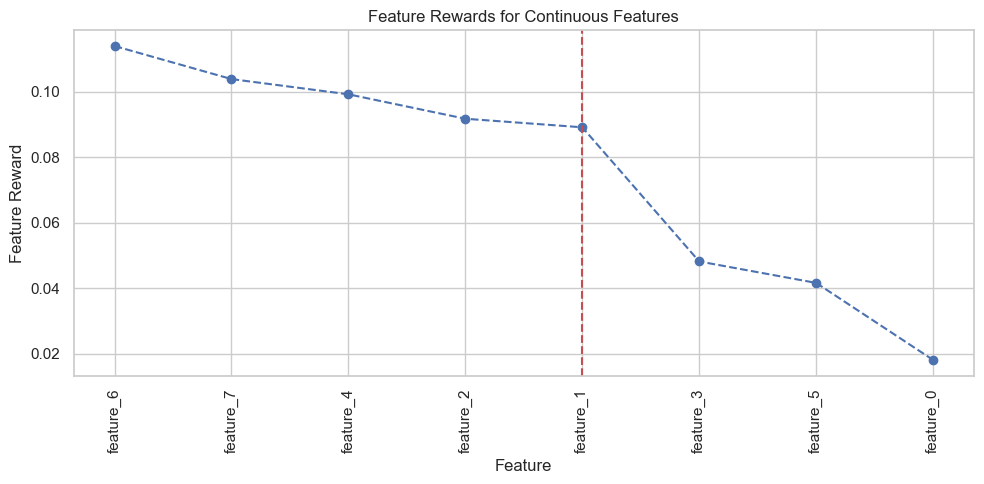

Trace ID: 3_2, Anomaly ID: 3


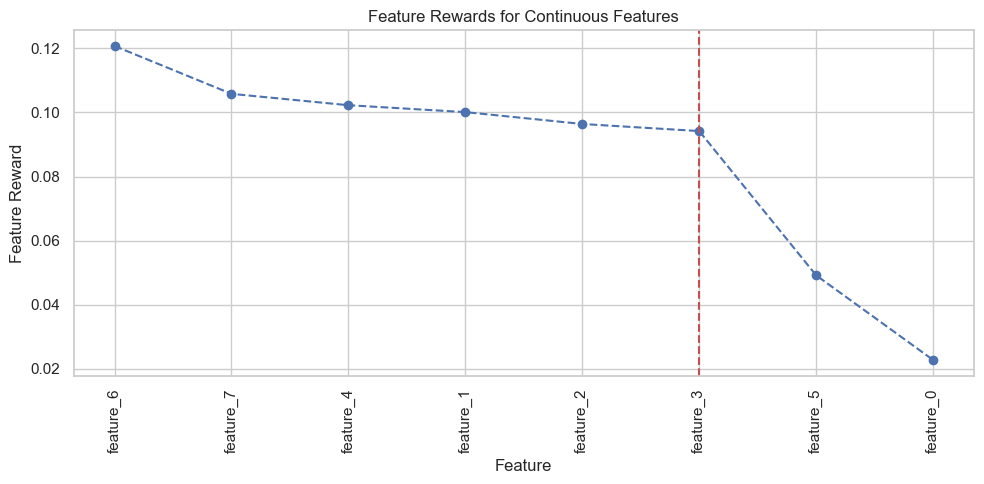

Trace ID: 3_2, Anomaly ID: 4


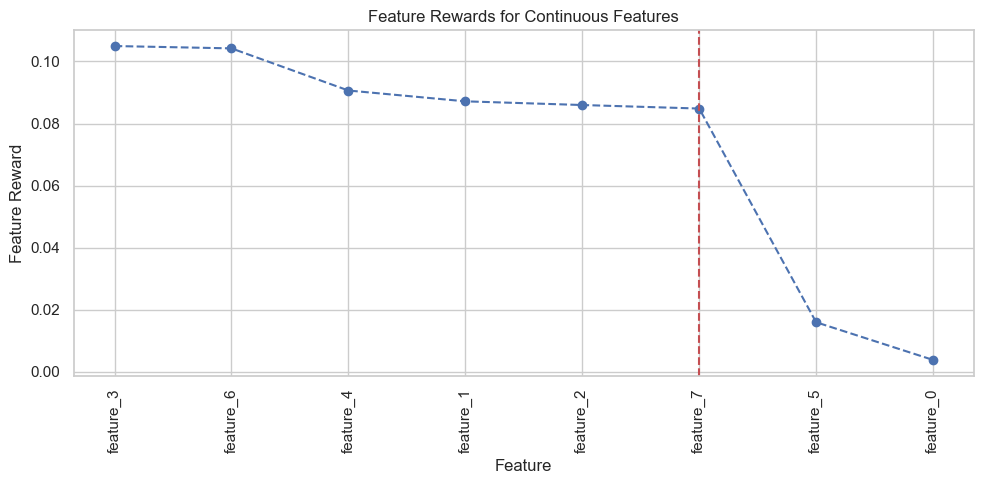

In [33]:
anomalies = labels_df[['trace_id', 'ano_id']].values.tolist()

for trace_id, ano_id in anomalies:
    print(f"Trace ID: {trace_id}, Anomaly ID: {ano_id}")
    # Générer l'explication
    explanation_features = build_explanation(
        anomaly_df[anomaly_df["trace_id"] == trace_id], 
        trace_id=trace_id, 
        ano_id=ano_id, 
        features=features_code,
        plot_rewards=True, 
        plot_correlation=False,
        verbose=False,
        ignore_first=True
    )